### Behavioral modelling

#### Assumptions:

1. experienced utility is some function of displayed reward magnitude: 
    - simple model: $u(x) = x$ 
    - complex model: $u(x) = x^{\delta} \quad if \quad x>0$ or $u(x) = -\gamma |x|^{\delta} \quad if \quad x>0$
2. values (reflecting beliefs about probability) are learned with simple delta learning rule (TD model):
    - $V(a_t)=V(a_{t-1})+ \alpha [R-V(a_{t-i})]$
3. choice probabilites are probabilistic functions of expected utilities:
    - degenerate model: $p(a)=\frac{EV(a)}{EV(a)+EV(b)}$ (parsimoneous approach introduced by *Summerfield et al. 2011*)
    - full softmax model: $p(a)=\frac{\exp(\beta EV(a))}{\exp(\beta EV(a)) + \exp(\beta EV(b))}$

#### Free parameters:

- $\alpha \in [0, 1]$: learning rate (modelling learning rate above half would result in model selecting previously rewarded / not punished option which is not realistic 
- $\gamma \in [0, \infty]$: loss aversion parameter
- $\delta \in [0, 1]$: risk aversion parameter
- $\beta \in [0, \infty]$: inverse temperature for softmax function

#### Model variations:

- model 1: (k=1 parameter) simple utility model, degenerate model for choice probabilities
- model 2: (k=2 parameters) simple utility model, full softmax model
- model 3: (k=4 parameters) complex utility model, full softmax model


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
from utils import *

# plt.style.use('seaborn-ticks')

In [2]:
beh_path = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/" \
           "data/main_fmri_study/behavioral/behavioral_data_clean_all.npy"
beh_meta_path = beh_path.replace('npy', 'json')

# Load behavioral data
beh = np.load(beh_path)
with open(beh_meta_path, 'r') as f:
    meta = json.loads(f.read())
    
print("Shape of beh array:", beh.shape)
print("Conditions", [(i, cond) for i, cond in enumerate(meta['dim2'])])
print("Columns:", [(i, col) for i, col in enumerate(meta['dim4'])])

n_subjects = beh.shape[0]
n_conditions = beh.shape[1]
n_trials = beh.shape[2]

Shape of beh array: (32, 2, 110, 21)
Conditions [(0, 'rew'), (1, 'pun')]
Columns: [(0, 'block'), (1, 'rwd'), (2, 'magn_left'), (3, 'magn_right'), (4, 'response'), (5, 'rt'), (6, 'won_bool'), (7, 'won_magn'), (8, 'acc_after_trial'), (9, 'onset_iti'), (10, 'onset_iti_plan'), (11, 'onset_iti_glob'), (12, 'onset_dec'), (13, 'onset_dec_plan'), (14, 'onset_dec_glob'), (15, 'onset_isi'), (16, 'onset_isi_plan'), (17, 'onset_isi_glob'), (18, 'onset_out'), (19, 'onset_out_plan'), (20, 'onset_out_glob')]


### Show example model fit for models 1 and 2
Models are fitted to subject responses using $G^2$ which is a measure of badness-of-fit derived from log likelyhood. In this section model 1 and 2 are fitted for all possible parameters sampled from parameter space. Both task conditions are fitted separately for single subject. Finally, $G^2$  function is visualised in the parameter space.

/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/code/behavioral_analysis/utils.py:109: RuntimeWarning: divide by zero encountered in log
  ll += np.log(p[trial, 0])
/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/code/behavioral_analysis/utils.py:111: RuntimeWarning: divide by zero encountered in log
  ll += np.log(p[trial, 1])


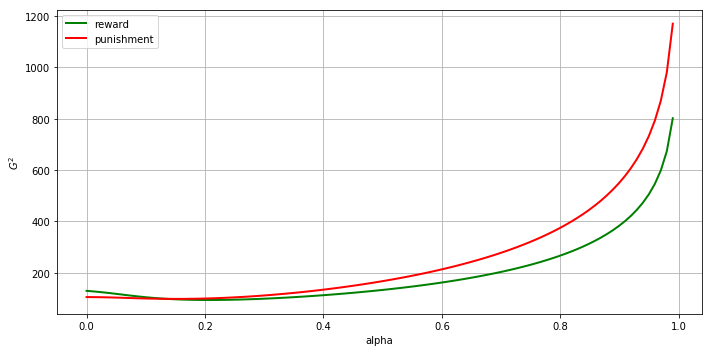

In [3]:
N_grid = 100
subject = 1

### Model 1 #################################################################
alpha = np.linspace(0, 1, N_grid)

fit1 = np.zeros((2, N_grid))
for i, a in enumerate(alpha):
    fit1[0, i] = g_square(beh, meta, subject, 0, 
                          model1(beh, meta, subject, 0, a)[2])
    fit1[1, i] = g_square(beh, meta, subject, 1, 
                          model1(beh, meta, subject, 1, a)[2])
    
    
# Figure 1
fig1, ax = plt.subplots(facecolor='w', figsize=(10, 5))
ax.plot(alpha, fit1[0,:], linewidth=2, color='g', label='reward')
ax.plot(alpha, fit1[1,:], linewidth=2, color='r', label='punishment')

ax.set_ylabel('$G^2$')
ax.set_xlabel('alpha')
ax.legend()
ax.grid()

plt.tight_layout()

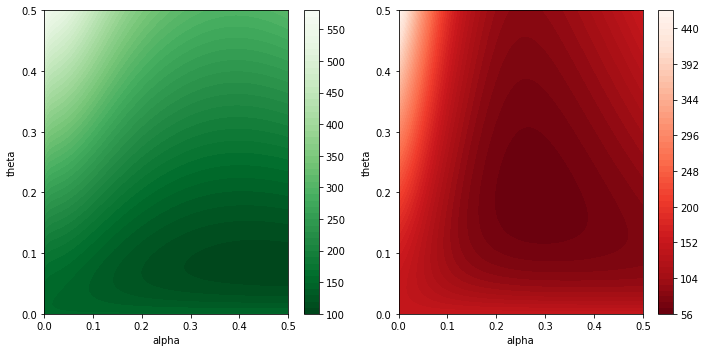

In [4]:
N_grid = 100
subject = 27

## Model 2 #################################################################
alpha = np.linspace(0, .5, N_grid)
theta = np.linspace(0, .5, N_grid)

av, tv = np.meshgrid(alpha, theta)

fit2 = np.zeros((2, N_grid, N_grid))
for i, a in enumerate(alpha):
    for j, t in enumerate(theta):
        fit2[0, i, j] = g_square(beh, meta, subject, 0,
                                 model2(beh, meta, subject, 0, a, t)[2])
        fit2[1, i, j] = g_square(beh, meta, subject, 1,
                                 model2(beh, meta, subject, 1, a, t)[2])

# Figure 2
fig2, (ax2r, ax2p) = plt.subplots(nrows=1, ncols=2, 
                                  facecolor='w', figsize=(10, 5))
im2r = ax2r.contourf(alpha, theta, fit2[0].T, levels=50, cmap='Greens_r')
im2p = ax2p.contourf(alpha, theta, fit2[1].T, levels=50, cmap='Reds_r')

ax2r.set_xlabel('alpha')
ax2r.set_ylabel('theta')
ax2p.set_xlabel('alpha')
ax2p.set_ylabel('theta')

fig2.colorbar(im2r, ax=ax2r)
fig2.colorbar(im2p, ax=ax2p)

plt.tight_layout()

### Model fitting for single subject responses
In this section model parameters are optimized for explaining subject responses. Behavioral responsed are pooled across both task conditions.  

In [5]:
from scipy.optimize import minimize
from scipy.optimize import Bounds

In [ ]:
bounds1 = Bounds([0], [1])
x0 = np.array([.5])

def cost_model1(x):
    '''Optimization function for model 1.'''
    global subject
    g_rew = g_square(beh, meta, subject, 0, model1(beh, meta, subject, 0, x)[2])
    g_pun = g_square(beh, meta, subject, 1, model1(beh, meta, subject, 1, x)[2])
    return g_rew + g_pun

params_1 = np.zeros((n_subjects, 2)) # store results

for subject in range(n_subjects):

    print(f'Finding parameter for subject {subject}...')
    res1 = minimize(cost_model1, x0, method='SLSQP', bounds=bounds1)
    params_1[subject, 0] = res1['x']
    params_1[subject, 1] = res1['fun']

In [12]:
bounds2 = Bounds([0, 0], [1, np.inf])
x0 = np.array([.5, 1])

def cost_model2(x):
    '''Optimization function for model 2.'''
    g_rew = g_square(beh, meta, subject, 0, 
                     model2(beh, meta, subject, 0, x[0], x[1])[2])
    return g_rew

params_2 = np.zeros((n_subjects, 3)) # store results

for subject in range(n_subjects):

    res2 = minimize(cost_model2, x0, method='SLSQP', bounds=bounds2)
    params_2[subject][0] = res2['x'][0] # alpha
    params_2[subject][1] = res2['x'][1] # theta
    params_2[subject][2] = res2['fun']

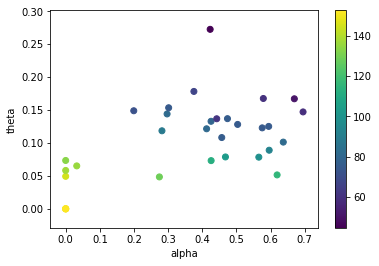

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, facecolor='w')

sp = ax.scatter(params_2[:,0], params_2[:, 1], c=params_2[:, 2])
ax.set_xlabel('alpha')
ax.set_ylabel('theta')

plt.colorbar(sp)

### Model comparison for single subject
In this section three models are compared with respect to their Akaike Information Criterion (AIC score). AIC enables comparision of models with different number of free parameters. AIC is defined as:
$$AIC = G^2 + 2k$$ 

In [ ]:
subject = 1

results = {}
results['model1'] = {'k': 1, 'g_square': None, 'x': None}
results['model2'] = {'k': 2, 'g_square': None, 'x': None}
results['model3'] = {'k': 4, 'g_square': None, 'x': None}

### Model 1 #################################################################
bounds1 = Bounds([0], [1])

def cost_model1(x):
    '''Optimization function for model 1.'''
    g_rew = g_square(beh, meta, subject, 0, model1(beh, meta, subject, 0, x))
    g_pun = g_square(beh, meta, subject, 1, model1(beh, meta, subject, 1, x))
    return g_rew  + g_pun

x0 = np.array([.5])

res1 = minimize(cost_model1, x0, method='SLSQP', bounds=bounds1)
results['model1']['g_square'] = res1['fun']
results['model1']['x'] = res1['x']

### Model 2 #################################################################
bounds2 = Bounds([0, 0], [1, np.inf])

def cost_model2(x):
    '''Optimization function for model 2.'''
    g_rew = g_square(beh, meta, subject, 0, 
                     model2(beh, meta, subject, 0, x[0], x[1]))
    g_pun = g_square(beh, meta, subject, 1, 
                     model2(beh, meta, subject, 1, x[0], x[1]))
    return g_rew + g_pun

x0 = np.array([.5, 1])

res2 = minimize(cost_model2, x0, method='SLSQP', bounds=bounds2)    
results['model2']['g_square'] = res2['fun']
results['model2']['x'] = res2['x']

# ### Model 3 #################################################################
bounds3 = Bounds([0, 0, 0, 0], [1, np.inf, np.inf, 1])

def cost_model3(x):
    '''Optimization function for model 3.'''
    g_rew = g_square(beh, meta, subject, 0, 
                     model3(beh, meta, subject, 0, x[0], x[1], x[2], x[3]))
    g_pun = g_square(beh, meta, subject, 1, 
                     model3(beh, meta, subject, 1, x[0], x[1], x[2], x[3]))
    return g_rew + g_pun

x0 = np.array([.5, .5, 1, 1])

res3 = minimize(cost_model3, x0, method='SLSQP', bounds=bounds3)    
results['model3']['g_square'] = res3['fun'] 
results['model3']['x'] = res3['x']

In [ ]:
aic = np.zeros(3)

for i, model in enumerate(results):
    aic[i] = results[model]['g_square'] + 2*results[model]['k']

plt.style.use('seaborn-ticks')

fig, ax = plt.subplots(facecolor='w', figsize=(10, 3))

color = ['#01579B' for _ in range(3)]
color[np.argmin(aic)] = '#A67C00'
ax.barh(range(3), aic, color=color, alpha=.75)
ax.set_xlabel('Akaike Information Criterion')
ax.set_yticks(range(3))
ax.set_yticklabels(['model1', 'model2', 'model3'])
ax.grid()